In [78]:
import pandas as pd
import numpy as np
import requests
from scipy import stats
from bs4 import BeautifulSoup
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

df = pd.read_html("https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures",
                   attrs={"id":"sched_2024-2025_9_1"})[0]


In [79]:
#Leauge Table 
table = pd.read_html("https://fbref.com/en/comps/9/Premier-League-Stats",
                   attrs={"id": "results2024-202591_overall"})[0]

table = table.set_index("Rk")

In [80]:
def quick_sort_accending(df, column):
    if len(df) <= 1:
        return df
    pivot = df.iloc[len(df) // 2] 

    less_than_pivot = df[df[column] < pivot[column]]
    equal_to_pivot = df[df[column] == pivot[column]]
    greater_than_pivot = df[df[column] > pivot[column]]
    
    sorted_less = quick_sort_accending(less_than_pivot, column)
    sorted_greater = quick_sort_accending(greater_than_pivot, column)

    return pd.concat([sorted_less, equal_to_pivot, sorted_greater])

In [81]:
def quick_sort_descending(df, column):
    if len(df) <= 1:
        return df
    pivot = df.iloc[len(df) // 2] 

    less_than_pivot = df[df[column] < pivot[column]]
    equal_to_pivot = df[df[column] == pivot[column]]
    greater_than_pivot = df[df[column] > pivot[column]]
    
    sorted_less = quick_sort_descending(less_than_pivot, column)
    sorted_greater = quick_sort_descending(greater_than_pivot, column)

    return pd.concat([sorted_greater, equal_to_pivot, sorted_less])


In [82]:
table_df = table.copy()
table_df_2 = table_df.copy()
table_df.drop(["Attendance", "Goalkeeper", "Notes"], inplace= True, axis = 1)

In [83]:
def transformed(row):
    #row["Attack"] = row["GF"] + row["xG"]// row['MP']
    row["Attack"] = (row["GF"] + row["xG"])/row['MP']
    row["Defence"] = (row["GA"] + row["xGA"])/row['MP']
    return row 
new_table_df = table_df.apply(transformed, axis=1)

In [84]:
# Reset index and add RK column
sorted_attack_table_df = quick_sort_descending(new_table_df, "Attack")
sorted_attack_table_df = sorted_attack_table_df.reset_index(drop=True)
sorted_attack_table_df["RK"] = sorted_attack_table_df.index + 1
sorted_attack_table_df = sorted_attack_table_df.set_index("RK")

In [85]:
# Reset index and add RK column
sorted_defence_table_df = quick_sort_accending(new_table_df, "Defence")
sorted_defence_table_df = sorted_defence_table_df.reset_index(drop=True)
sorted_defence_table_df["RK"] = sorted_defence_table_df.index + 1
sorted_defence_table_df = sorted_defence_table_df.set_index("RK")

In [86]:
df_one = df[["Home", "xG", "Score", "xG.1", "Away"]]

def divideScore(row):
    if pd.notna(row['Score']) and '–' in row['Score']:
        # Split the Score column into two parts (Score1 and Score2)
        score1, score2 = row['Score'].split('–')
        row['Score1'] = score1
        row['Score2'] = score2
    else:
        # Set NaN if there's no valid score to split
        row['Score1'] = None    
        row['Score2'] = None
    return row

df_two = df_one.apply(divideScore, axis=1)
df_three= df_two.rename(columns={"Score1": "HGoal", "Score2": 'AGoal'})
df_four = df_three[["Home", "HGoal", "AGoal", "Away"]]
df_cleaned = df_four.dropna(how='all')

In [87]:
class TeamState:
    def __init__(self, df, table):
        self.df = df
        self.table = table
          
    def mean_or_zero(self, goals_list):
        return round(np.mean(goals_list), 2) if goals_list else 0
        
    def median_or_zero(self, goals_list):
        return round(np.median(goals_list), 2) if goals_list else 0
        
    def mode_or_zero(self, goals_list):
        return round(stats.mode(goals_list, keepdims=False).mode, 2) if goals_list else 0
        
    def std(self, goals_list):
        return round(np.std(goals_list), 2) if goals_list else 0   
        
    # All Performance of the team 
    def performance(self, team):
        performance_dict = {}
        for index, row in self.df.iterrows():
            if (row["Home"] == team or row['Away'] == team) and pd.notna(row['HGoal']) and pd.notna(row["AGoal"]):
                if row["Home"] == team:
                    if row["HGoal"] > row["AGoal"]:
                        performance_dict[row["Away"]] = 1
                    elif row["HGoal"] == row["AGoal"]:
                        performance_dict[row["Away"]] = 0.25
                    elif row["HGoal"] < row["AGoal"]:
                        performance_dict[row["Away"]] = -1
                        
                elif row["Away"] == team:
                    if row["AGoal"] > row["HGoal"]:
                        performance_dict[row["Home"]] = 1
                    elif row["AGoal"] == row["HGoal"]:
                        performance_dict[row["Home"]] = 0.25
                    elif row["AGoal"] < row["HGoal"]:
                        performance_dict[row["Home"]] = -1
        return performance_dict 
                    
     
    #Home Performance of the team   
    def home_performance(self, team):
        home_dict = {}
        for index, row in self.df.iterrows():
            if row["Home"] == team and pd.notna(row["HGoal"]) and pd.notna(row["AGoal"]):
                if row["HGoal"] > row["AGoal"]:
                    home_dict[row["Away"]] = 1
                elif row["HGoal"] == row["AGoal"]:
                    home_dict[row["Away"]] = 0.25
                else:
                    home_dict[row["Away"]] = -1
        return home_dict
    
    #Away Performance of the team 
    def away_performance(self, team):
        away_dict = {}
        for index, row in self.df.iterrows():
            if row["Away"] == team and pd.notna(row["HGoal"]) and pd.notna(row["AGoal"]):
                if row["AGoal"] > row["HGoal"]:
                    away_dict[row["Home"]] = 1
                elif row["HGoal"] == row["AGoal"]:
                    away_dict[row["Home"]] = 0.25
                else:
                    away_dict[row["Home"]] = -1
        return away_dict
    
    # Goal Score by the team in home   
    def home_goal_scored(self, team):
        home_goal_dict = {}
        for index, row in self.df.iterrows():
            if row["Home"] == team and pd.notna(row["HGoal"]) and pd.notna(row["AGoal"]):
                if int(row["HGoal"]) == 0: 
                    home_goal_dict[row['Away']] = 0.25
                else:                 
                    home_goal_dict[row['Away']] = int(row["HGoal"])         
        return home_goal_dict
    
    # Goal Score by the team in Away   
    def away_goal_scored(self, team):
        away_goal_dict = {}
        for index, row in self.df.iterrows():   
            if row["Away"] == team and pd.notna(row["HGoal"]) and pd.notna(row["AGoal"]):
                if int(row["AGoal"]) == 0: 
                    away_goal_dict[row['Home']] = 0.25
                else:                 
                    away_goal_dict[row['Home']] = int(row["AGoal"])          
        return away_goal_dict
    
   # Goal consided by the team in home match 
    def home_goal_consided(self, team):
        home_goal_consided_dict = {}
        for index, row in self.df.iterrows():
            if row["Home"] == team and pd.notna(row["HGoal"]) and pd.notna(row["AGoal"]):
                if int(row["AGoal"]) == 0: 
                    home_goal_consided_dict[row['Away']] = 0.25
                else:       
                    home_goal_consided_dict[row['Away']] = int(row["AGoal"])        
        return home_goal_consided_dict
    
    # Goal consided by the team in away match 
    def away_goal_consided(self, team):
        away_goal_consided_dict = {}
        for index, row in self.df.iterrows():
            if row["Away"] == team and pd.notna(row["HGoal"]) and pd.notna(row["AGoal"]):
                if int(row["HGoal"]) == 0:
                    away_goal_consided_dict[row['Home']] = 0.25
                else:    
                    away_goal_consided_dict[row['Home']] = int(row["HGoal"])         
        return away_goal_consided_dict
    
    #Calculation
    #Goal Against All Teams for both teams
    def goal_against_all(self, team):
        team_goals = []
        for index, row in self.df.iterrows():
            if row["Home"] == team and pd.notna(row["HGoal"]):
                team_goals.append(int(row["HGoal"]))
            elif row["Away"] == team and pd.notna(row["AGoal"]):
                team_goals.append(int(row['AGoal']))

        return (team_goals, [self.mean_or_zero(team_goals), self.median_or_zero(team_goals), self.mode_or_zero(team_goals), self.std(team_goals)])  
    
    
    # Goal consided Against All Teams for both teams
    def goal_consided_all(self, team):
        team_goals = []
        for index, row in self.df.iterrows():
            if row["Home"] == team and pd.notna(row["HGoal"]):
                team_goals.append(int(row["AGoal"]))
            elif row["Away"] == team and pd.notna(row["AGoal"]):
                team_goals.append(int(row['HGoal']))
                
        return (team_goals, [self.mean_or_zero(team_goals), self.median_or_zero(team_goals), self.mode_or_zero(team_goals), self.std(team_goals)]) 
    
    #Goal Scored in Home 
    def homePerformance(self, team):
        home_team_goal_scored = []
        home_team_goal_consided = []
        for index, row in self.df.iterrows():
            if row["Home"] == team and pd.notna(row["HGoal"]) and pd.notna(row["AGoal"]):
                home_team_goal_scored.append(int(row["HGoal"]))
                home_team_goal_consided.append(int(row["AGoal"]))   
                         
        return f'Goal Scored Mean, Median, Mode, STD (Home): ({home_team_goal_scored}, {[self.mean_or_zero(home_team_goal_scored), self.median_or_zero(home_team_goal_scored), self.mode_or_zero(home_team_goal_scored), self.std(home_team_goal_scored)]}) \nGoal Consided Mean, Median, Mode, STD (Home): ({home_team_goal_consided}, {[self.mean_or_zero(home_team_goal_consided), self.median_or_zero(home_team_goal_consided), self.mode_or_zero(home_team_goal_consided), self.std(home_team_goal_consided)]})'
    
    #Goal Scored in Away 
    def awayPerformance(self, team):
        away_goal_scored = []
        away_goal_consided = []
        for index, row in self.df.iterrows():
            if row["Away"] == team and pd.notna(row["AGoal"]) and pd.notna(row["HGoal"]):
                away_goal_scored.append(int(row["AGoal"]))
                away_goal_consided.append(int(row["HGoal"]))  
                          
        return f'Goal Scored Mean, Median, Mode, STD (Away): ({away_goal_scored}, {[self.mean_or_zero(away_goal_scored), self.median_or_zero(away_goal_scored), self.mode_or_zero(away_goal_scored), self.std(away_goal_scored)]}) \nGoal Consided Mean, Median, Mode, STD (Away): ({away_goal_consided}, {[self.mean_or_zero(away_goal_consided), self.median_or_zero(away_goal_consided), self.mode_or_zero(away_goal_consided), self.std(away_goal_consided)]})'
    
    # Recent 5 Matches Goals for both teams
    def recent_five_match_goal_scored(self, team):
        goals, _ = self.goal_against_all(team)
        return goals[-5:], [self.mean_or_zero(goals[-5:]), self.median_or_zero(goals[-5:]), self.mode_or_zero(goals[-5:]), self.std(goals[-5:])]
    
    # Recent 5 Matches Goals for both teams
    def recent_five_match_goal_consided(self, team):
        goals, _ = self.goal_consided_all(team)
        return goals[-5:], [self.mean_or_zero(goals[-5:]), self.median_or_zero(goals[-5:]), self.mode_or_zero(goals[-5:]), self.std(goals[-5:])]
    
    #new Features for the sorted df plot 
    def goal_against_all_tiers_sorted(self, team, sorted_table):
        tiers = {
            'first_tier': range(1, 6),
            'second_tier': range(6, 10),
            'third_tier': range(10, 15),
            'fourth_tier': range(15, 21)
        }
        
        tier_teams = {
            tier: [row["Squad"] for index, row in sorted_table.iterrows() if index in indices]
            for tier, indices in tiers.items()
        }
        
        goals_against_tiers = {tier: [] for tier in tier_teams}
    
        for index, row in self.df.iterrows():
            for tier, teams in tier_teams.items():
                if row['Home'] == team and row['Away'] in teams and pd.notna(row["HGoal"]):
                    goals_against_tiers[tier].append(int(row['HGoal']))
                elif row['Away'] == team and row['Home'] in teams and pd.notna(row["AGoal"]):
                    goals_against_tiers[tier].append(int(row['AGoal']))
                    
        def mean_or_zero(goals_list):
            return round(np.mean(goals_list), 2) if goals_list else 0
        
        def median_or_zero(goals_list):
            return round(np.median(goals_list), 2) if goals_list else 0
        
        def mode_or_zero(goals_list):
            return round(stats.mode(goals_list, keepdims=False).mode, 2) if goals_list else 0
        
        def std(goals_list):
            return round(np.std(goals_list), 2) if goals_list else 0

        return (
            f"Mean, Median, Mode, STD Goals Scored Against First Tier Defence Teams: ({goals_against_tiers['first_tier']}, [{mean_or_zero(goals_against_tiers['first_tier'])}, {median_or_zero(goals_against_tiers['first_tier'])}, {mode_or_zero(goals_against_tiers['first_tier'])}, {std(goals_against_tiers['first_tier'])}])\n"
            
            f"Mean, Median, Mode, STD Goals Scored Against Second Tier Defence Teams: ( {goals_against_tiers['second_tier']}, [{mean_or_zero(goals_against_tiers['second_tier'])}, {median_or_zero(goals_against_tiers['second_tier'])}, {mode_or_zero(goals_against_tiers['second_tier'])}, {std(goals_against_tiers['second_tier'])}])\n"
            
            f"Mean, Median, Mode, STD Goals Scored Against Third Tier Defence Teams: ( {goals_against_tiers['third_tier']}, [{mean_or_zero(goals_against_tiers['third_tier'])}, {median_or_zero(goals_against_tiers['third_tier'])}, {mode_or_zero(goals_against_tiers['third_tier'])}, {std(goals_against_tiers['third_tier'])}])\n"
            
            f"Mean, Median, Mode, STD Goals Scored Against Third Tier Defence Teams: ( {goals_against_tiers['fourth_tier']}, [{mean_or_zero(goals_against_tiers['fourth_tier'])}, {median_or_zero(goals_against_tiers['fourth_tier'])}, {mode_or_zero(goals_against_tiers['fourth_tier'])}, {std(goals_against_tiers['fourth_tier'])}])\n"
        )
    
    def goal_consided_all_tiers_sorted(self, team, sorted_table):
        tiers = {
            'first_tier': range(1, 6),
            'second_tier': range(6, 10),
            'third_tier': range(10, 15),
            'fourth_tier': range(15, 21)
        }
        
        tier_teams = {
            tier: [row["Squad"] for index, row in sorted_table.iterrows() if index in indices]
            for tier, indices in tiers.items()
        }
        
        goals_against_tiers = {tier: [] for tier in tier_teams}
    
        for index, row in self.df.iterrows():
            for tier, teams in tier_teams.items():
                if row['Home'] == team and row['Away'] in teams and pd.notna(row["HGoal"]):
                    goals_against_tiers[tier].append(int(row['AGoal']))
                elif row['Away'] == team and row['Home'] in teams and pd.notna(row["AGoal"]):
                    goals_against_tiers[tier].append(int(row['HGoal']))
                    
        def mean_or_zero(goals_list):
            return round(np.mean(goals_list), 2) if goals_list else 0
        
        def median_or_zero(goals_list):
            return round(np.median(goals_list), 2) if goals_list else 0
        
        def mode_or_zero(goals_list):
            return round(stats.mode(goals_list, keepdims=False).mode, 2) if goals_list else 0
        
        def std(goals_list):
            return round(np.std(goals_list), 2) if goals_list else 0

        return (
            f"Mean, Median, Mode, STD Goals Consided Against First Tier Attack Teams: ({goals_against_tiers['first_tier']}, [{mean_or_zero(goals_against_tiers['first_tier'])}, {median_or_zero(goals_against_tiers['first_tier'])}, {mode_or_zero(goals_against_tiers['first_tier'])}, {std(goals_against_tiers['first_tier'])}])\n"
            
            f"Mean, Median, Mode, STD Goals Consided Against Second Tier Attack Teams: ({goals_against_tiers['second_tier']},[{mean_or_zero(goals_against_tiers['second_tier'])}, {median_or_zero(goals_against_tiers['second_tier'])}, {mode_or_zero(goals_against_tiers['second_tier'])}, {std(goals_against_tiers['second_tier'])}])\n"
            
            f"Mean, Median, Mode, STD Goals Consided Against Third Tier Attack Teams: ( {goals_against_tiers['third_tier']}, [{mean_or_zero(goals_against_tiers['third_tier'])}, {median_or_zero(goals_against_tiers['third_tier'])}, {mode_or_zero(goals_against_tiers['third_tier'])}, {std(goals_against_tiers['third_tier'])}])\n"
            
            f"Mean, Median, Mode, STD Goals Consided Against Third Tier Attack Teams: ( {goals_against_tiers['fourth_tier']}, [{mean_or_zero(goals_against_tiers['fourth_tier'])}, {median_or_zero(goals_against_tiers['fourth_tier'])}, {mode_or_zero(goals_against_tiers['fourth_tier'])}, {std(goals_against_tiers['fourth_tier'])}])\n"
        ) 
    

In [88]:
state = TeamState(df_cleaned, table_df)

In [89]:
def showall_data(team):
    print(f'Goal Score Against All {state.goal_against_all(team)}')
    print(f'Goal Consided Against All {state.goal_consided_all(team)}\n')
    print(f'Goal Scored (Recent Five Match): {state.recent_five_match_goal_scored(team)}')
    print(f'Goal Consided (Recent Five Match): {state.recent_five_match_goal_consided(team)}\n')
    print(state.homePerformance(team), "\n")
    print(state.awayPerformance(team), "\n")
    print(state.goal_against_all_tiers_sorted(team, sorted_defence_table_df))
    print(state.goal_consided_all_tiers_sorted(team, sorted_attack_table_df))

In [90]:
def plot_team_performance(team, state):
    home_perf = state.home_performance(team)
    away_perf = state.away_performance(team)
    home_scored = state.home_goal_scored(team)
    home_conceded = state.home_goal_consided(team)
    away_scored = state.away_goal_scored(team)
    away_conceded = state.away_goal_consided(team)
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 9))
    
    # Plot 1: Home Performance (Win/Loss/Draw)
    axs[0, 0].bar(home_perf.keys(), home_perf.values(), color=['g' if v==1 else 'r' if v==-1 else 'gray' for v in home_perf.values()])
    axs[0, 0].set_title(f'{team} Home Performance')
    axs[0, 0].set_ylabel("Result (Win=1, Draw=0, Loss=-1)")
    axs[0, 0].tick_params(axis='x', rotation=50)
    
    # Plot 2: Away Performance (Win/Loss/Draw)
    axs[0, 1].bar(away_perf.keys(), away_perf.values(), color=['g' if v==1 else 'r' if v==-1 else 'gray' for v in away_perf.values()])
    axs[0, 1].set_title(f'{team} Away Performance')
    axs[0, 1].set_ylabel("Result (Win=1, Draw=0, Loss=-1)")
    axs[0, 1].tick_params(axis='x', rotation=50)
    
    # Plot 3: Home Goals Scored vs. Conceded
    home_teams = list(home_scored.keys())
    x = np.arange(len(home_teams))
    width = 0.25
    axs[1, 0].bar(x - width/2, home_scored.values(), width=width, label='Goals Scored', color='blue')
    axs[1, 0].bar(x + width/2, home_conceded.values(), width=width, label='Goals Conceded', color='red')
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(home_teams, rotation=45)
    axs[1, 0].set_title(f'{team} Home Goals Scored vs Conceded')
    axs[1, 0].legend()
    
    # Plot 4: Away Goals Scored vs. Conceded
    away_teams = list(away_scored.keys())
    x = np.arange(len(away_teams))
    axs[1, 1].bar(x - width/2, away_scored.values(), width=width, label='Goals Scored', color='blue')
    axs[1, 1].bar(x + width/2, away_conceded.values(), width=width, label='Goals Conceded', color='red')
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(away_teams, rotation=45)
    axs[1, 1].set_title(f'{team} Away Goals Scored vs Conceded')
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    

In [91]:
new_table_df

,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Last 5,Top Team Scorer,Attack,Defence
Rk,,,,,,,,,,,,,,,,,,
1,Liverpool,29,21,7,1,69,27,42,70,2.41,65.0,25.1,39.8,1.37,W D W W W,Mohamed Salah - 27,4.620690,1.796552
2,Arsenal,28,15,10,3,52,24,28,55,1.96,43.8,24.4,19.4,0.69,W W L D D,Kai Havertz - 9,3.421429,1.728571
3,Nott'ham Forest,28,15,6,7,45,33,12,51,1.82,35.0,33.6,1.4,0.05,W L L D W,Chris Wood - 18,2.857143,2.378571
4,Chelsea,28,14,7,7,53,36,17,49,1.75,55.5,38.8,16.8,0.60,W L L W W,Cole Palmer - 14,3.875000,2.671429
5,Manchester City,28,14,5,9,53,38,15,47,1.68,49.7,37.4,12.3,0.44,L W L W L,Erling Haaland - 20,3.667857,2.692857
6,Newcastle Utd,28,14,5,9,47,38,9,47,1.68,46.3,35.4,10.9,0.39,L L W L W,Alexander Isak - 19,3.332143,2.621429
7,Brighton,28,12,10,6,46,40,6,46,1.64,41.6,39.3,2.3,0.08,L W W W W,João Pedro - 8,3.128571,2.832143
8,Aston Villa,29,12,9,8,41,45,-4,45,1.55,41.2,40.0,1.1,0.04,D D W L W,Ollie Watkins - 13,2.834483,2.931034
9,Bournemouth,28,12,8,8,47,34,13,44,1.57,51.3,37.9,13.4,0.48,L W L L D,Justin Kluivert - 12,3.510714,2.567857


In [92]:
sorted_attack_table_df

,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Last 5,Top Team Scorer,Attack,Defence
RK,,,,,,,,,,,,,,,,,,
1,Liverpool,29,21,7,1,69,27,42,70,2.41,65.0,25.1,39.8,1.37,W D W W W,Mohamed Salah - 27,4.620690,1.796552
2,Chelsea,28,14,7,7,53,36,17,49,1.75,55.5,38.8,16.8,0.60,W L L W W,Cole Palmer - 14,3.875000,2.671429
3,Manchester City,28,14,5,9,53,38,15,47,1.68,49.7,37.4,12.3,0.44,L W L W L,Erling Haaland - 20,3.667857,2.692857
4,Tottenham,28,10,4,14,55,41,14,34,1.21,46.3,47.4,-1.1,-0.04,W W W L D,"James Maddison, Brennan Johnson - 9",3.617857,3.157143
5,Bournemouth,28,12,8,8,47,34,13,44,1.57,51.3,37.9,13.4,0.48,L W L L D,Justin Kluivert - 12,3.510714,2.567857
6,Arsenal,28,15,10,3,52,24,28,55,1.96,43.8,24.4,19.4,0.69,W W L D D,Kai Havertz - 9,3.421429,1.728571
7,Newcastle Utd,28,14,5,9,47,38,9,47,1.68,46.3,35.4,10.9,0.39,L L W L W,Alexander Isak - 19,3.332143,2.621429
8,Brentford,28,11,5,12,48,44,4,38,1.36,43.9,43.6,0.3,0.01,L W W D L,Bryan Mbeumo - 15,3.282143,3.128571
9,Brighton,28,12,10,6,46,40,6,46,1.64,41.6,39.3,2.3,0.08,L W W W W,João Pedro - 8,3.128571,2.832143


In [93]:
sorted_defence_table_df

,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Last 5,Top Team Scorer,Attack,Defence
RK,,,,,,,,,,,,,,,,,,
1,Arsenal,28,15,10,3,52,24,28,55,1.96,43.8,24.4,19.4,0.69,W W L D D,Kai Havertz - 9,3.421429,1.728571
2,Liverpool,29,21,7,1,69,27,42,70,2.41,65.0,25.1,39.8,1.37,W D W W W,Mohamed Salah - 27,4.620690,1.796552
3,Nott'ham Forest,28,15,6,7,45,33,12,51,1.82,35.0,33.6,1.4,0.05,W L L D W,Chris Wood - 18,2.857143,2.378571
4,Crystal Palace,28,10,9,9,36,33,3,39,1.39,44.1,35.4,8.8,0.31,W L W W W,Jean-Philippe Mateta - 12,2.860714,2.442857
5,Everton,28,7,12,9,31,35,-4,33,1.18,30.6,34.8,-4.2,-0.15,D W D D D,"Iliman Ndiaye, Beto - 6",2.200000,2.492857
6,Fulham,28,11,9,8,41,38,3,42,1.50,38.8,32.1,6.8,0.24,W W L W L,Raúl Jiménez - 10,2.850000,2.503571
7,Bournemouth,28,12,8,8,47,34,13,44,1.57,51.3,37.9,13.4,0.48,L W L L D,Justin Kluivert - 12,3.510714,2.567857
8,Newcastle Utd,28,14,5,9,47,38,9,47,1.68,46.3,35.4,10.9,0.39,L L W L W,Alexander Isak - 19,3.332143,2.621429
9,Chelsea,28,14,7,7,53,36,17,49,1.75,55.5,38.8,16.8,0.60,W L L W W,Cole Palmer - 14,3.875000,2.671429


In [94]:
team_one = "Bournemouth"
team_two = "Brentford"

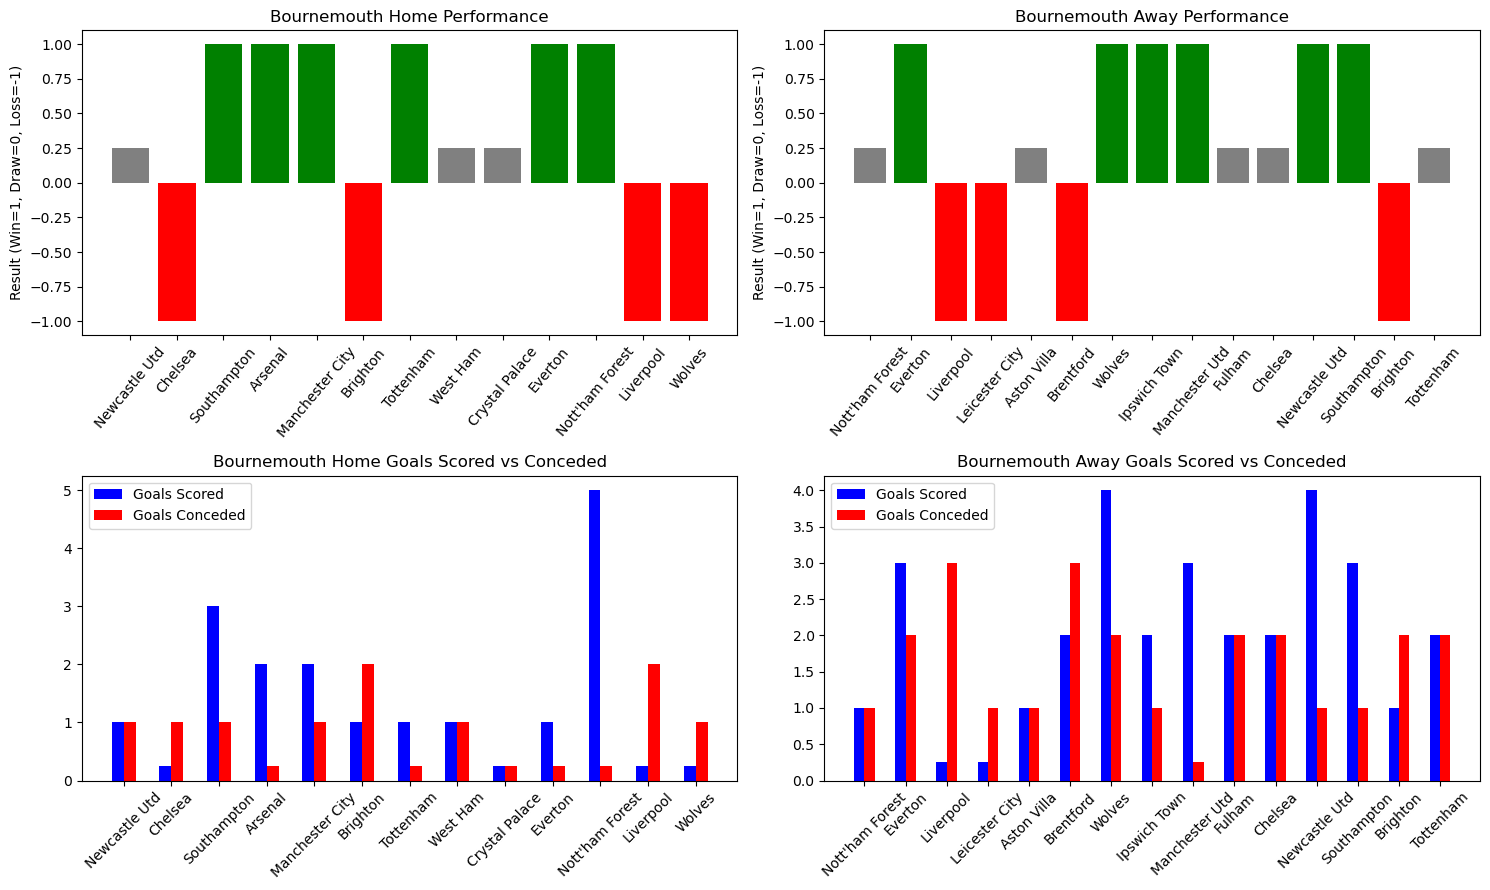

Goal Score Against All ([1, 1, 3, 0, 0, 3, 0, 2, 1, 2, 2, 1, 4, 1, 2, 1, 3, 0, 2, 1, 2, 4, 5, 0, 3, 0, 1, 2], [1.68, 1.5, 1, 1.34])
Goal Consided Against All ([1, 1, 2, 1, 3, 1, 1, 0, 1, 1, 3, 2, 2, 0, 1, 1, 0, 0, 2, 0, 2, 1, 0, 2, 1, 1, 2, 2], [1.21, 1.0, 1, 0.86])

Goal Scored (Recent Five Match): ([0, 3, 0, 1, 2], [1.2, 1.0, 0, 1.17])
Goal Consided (Recent Five Match): ([2, 1, 1, 2, 2], [1.6, 2.0, 2, 0.49])

Goal Scored Mean, Median, Mode, STD (Home): ([1, 0, 3, 2, 2, 1, 1, 1, 0, 1, 5, 0, 0], [1.31, 1.0, 1, 1.38]) 
Goal Consided Mean, Median, Mode, STD (Home): ([1, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 2, 1], [0.77, 1.0, 1, 0.7]) 

Goal Scored Mean, Median, Mode, STD (Away): ([1, 3, 0, 0, 1, 2, 4, 2, 3, 2, 2, 4, 3, 1, 2], [2.0, 2.0, 2, 1.21]) 
Goal Consided Mean, Median, Mode, STD (Away): ([1, 2, 3, 1, 1, 3, 2, 1, 0, 2, 2, 1, 1, 2, 2], [1.6, 2.0, 1, 0.8]) 

Mean, Median, Mode, STD Goals Scored Against First Tier Defence Teams: ([1, 3, 0, 2, 0, 1, 5, 0], [1.5, 1.0, 0, 1.66])
Mean, Median, Mo

In [95]:
plot_team_performance(team_one, state)
showall_data(team_one)

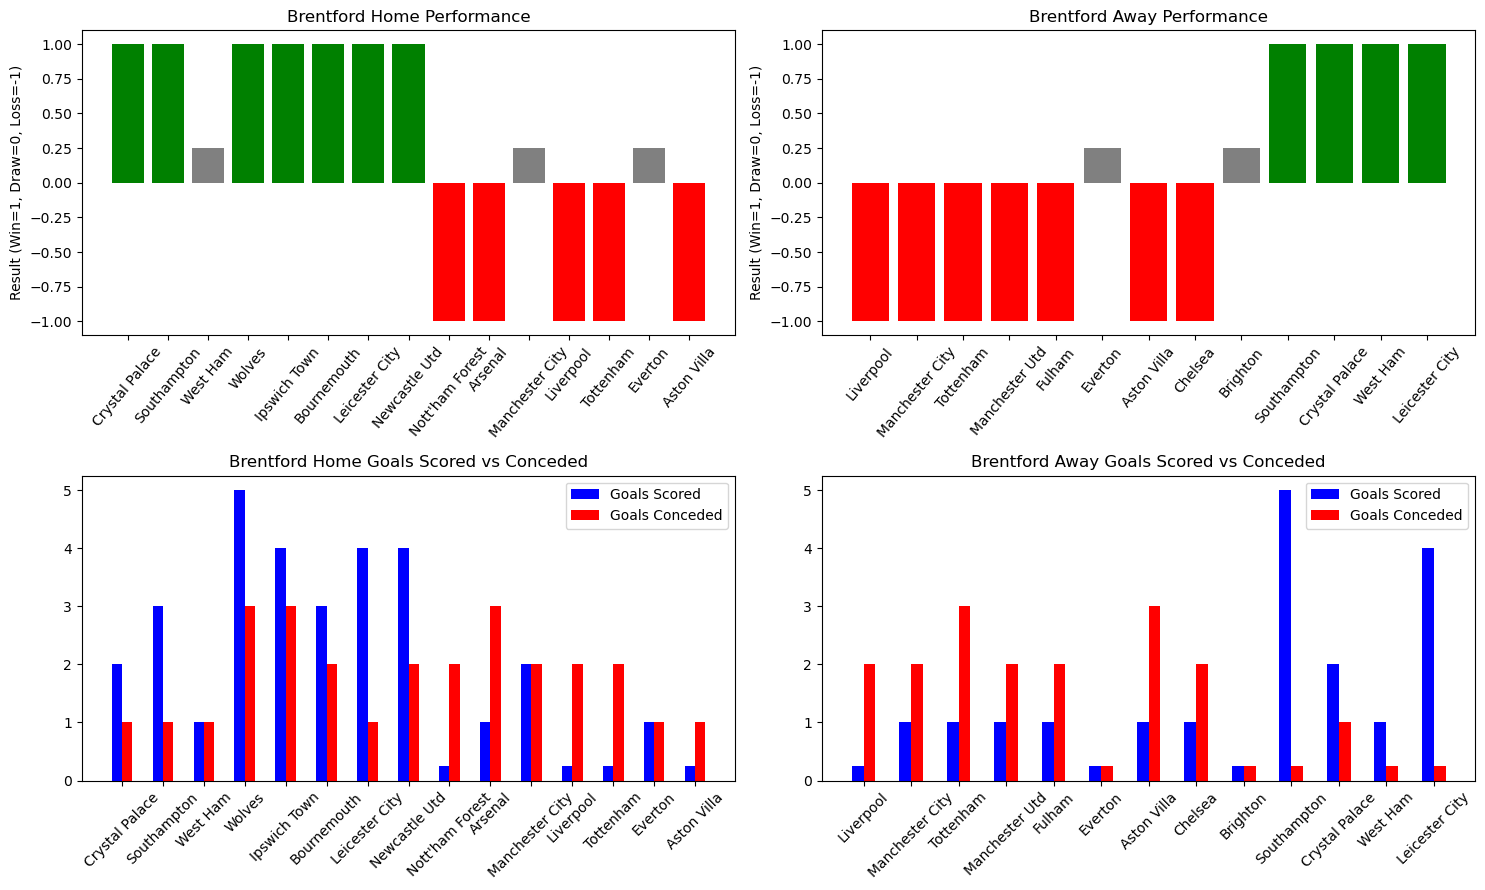

Goal Score Against All ([2, 0, 3, 1, 1, 1, 5, 1, 4, 1, 3, 0, 4, 1, 4, 1, 0, 0, 1, 5, 2, 0, 2, 0, 1, 4, 1, 0], [1.71, 1.0, 1, 1.6])
Goal Consided Against All ([1, 2, 1, 2, 3, 1, 3, 2, 3, 2, 2, 0, 1, 3, 2, 2, 2, 0, 3, 0, 2, 2, 1, 2, 0, 0, 1, 1], [1.57, 2.0, 2, 0.98])

Goal Scored (Recent Five Match): ([0, 1, 4, 1, 0], [1.2, 1.0, 0, 1.47])
Goal Consided (Recent Five Match): ([2, 0, 0, 1, 1], [0.8, 1.0, 0, 0.75])

Goal Scored Mean, Median, Mode, STD (Home): ([2, 3, 1, 5, 4, 3, 4, 4, 0, 1, 2, 0, 0, 1, 0], [2.0, 2.0, 0, 1.67]) 
Goal Consided Mean, Median, Mode, STD (Home): ([1, 1, 1, 3, 3, 2, 1, 2, 2, 3, 2, 2, 2, 1, 1], [1.8, 2.0, 1, 0.75]) 

Goal Scored Mean, Median, Mode, STD (Away): ([0, 1, 1, 1, 1, 0, 1, 1, 0, 5, 2, 1, 4], [1.38, 1.0, 1, 1.44]) 
Goal Consided Mean, Median, Mode, STD (Away): ([2, 2, 3, 2, 2, 0, 3, 2, 0, 0, 1, 0, 0], [1.31, 2.0, 0, 1.14]) 

Mean, Median, Mode, STD Goals Scored Against First Tier Defence Teams: ([2, 0, 0, 0, 1, 0, 2, 1], [0.75, 0.5, 0, 0.83])
Mean, Median, 

In [96]:
plot_team_performance(team_two, state)
showall_data(team_two)

In [ ]:
def LookUpTeam(team):
    assert team in table_df["Squad"].values, "Team not found"   
    return table_df[table_df["Squad"] == team]




In [ ]:
def headTohead(team):
    match = df_cleaned[(df_cleaned["Home"] == team) | (df_cleaned["Away"] == team)]
    return match